In [7]:
!pip install kaggle

In [8]:
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [9]:
!mkdir ~/.kaggle
!mv kaggle (2).json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists
/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `mv kaggle (2).json ~/.kaggle/'


In [10]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

In [11]:
!kaggle datasets download -d issaisasank/guns-object-detection

  0% 0.00/4.89M [00:00<?, ?B/s]
100% 4.89M/4.89M [00:00<00:00, 105MB/s]


In [12]:
!unzip guns-object-detection.zip

Archive:  guns-object-detection.zip
  inflating: Images/1.jpeg           
  inflating: Images/10.jpeg          
  inflating: Images/100.jpeg         
  inflating: Images/101.jpeg         
  inflating: Images/102.jpeg         
  inflating: Images/103.jpeg         
  inflating: Images/104.jpeg         
  inflating: Images/105.jpeg         
  inflating: Images/106.jpeg         
  inflating: Images/107.jpeg         
  inflating: Images/108.jpeg         
  inflating: Images/109.jpeg         
  inflating: Images/11.jpeg          
  inflating: Images/110.jpeg         
  inflating: Images/111.jpeg         
  inflating: Images/112.jpeg         
  inflating: Images/113.jpeg         
  inflating: Images/114.jpeg         
  inflating: Images/115.jpeg         
  inflating: Images/116.jpeg         
  inflating: Images/117.jpeg         
  inflating: Images/118.jpeg         
  inflating: Images/119.jpeg         
  inflating: Images/12.jpeg          
  inflating: Images/120.jpeg         
  inflating: I

In [13]:
import cv2
import numpy as np
from numpy.core.defchararray import join, mod
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A

from albumentations.pytorch.transforms import ToTensorV2
import os
from PIL import Image
import random
from tqdm.notebook import tqdm


import torch
import torch.nn as nn
from torch._C import device
import torch.optim as optim
import torch.autograd.grad_mode as grad_mode
from torch.autograd import Function as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms as torchtrans
from torch.utils.data import Dataset, DataLoader, random_split


from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.rpn import AnchorGenerator


if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device=torch.device("cpu")

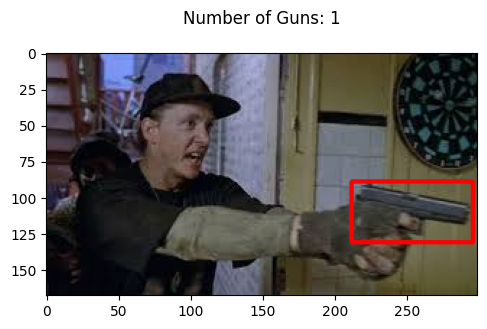

In [14]:
def imgshow(number, title=None, size=5):
    root="./"
    image=cv2.imread(root+"Images/"+str(number)+".jpeg")
    file=open(root+"Labels/"+str(number)+".txt", "r")
    txt_data = file.readlines()
    file.close()
    for i in range(0,int(txt_data[0])):
        indices=[int(x) for x in txt_data[i+1].split()]
        start_point=(indices[0], indices[1])
        end_point=(indices[2], indices[3])
        cv2.rectangle(image, start_point, end_point, (0,0,255), 2)
    aspect_ratio=image.shape[0]/image.shape[1]
    plt.figure(figsize=(size+aspect_ratio,size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title+txt_data[0])
    plt.show()

number=random.randint(1,334)
imgshow(number, title="Number of Guns: ")

In [15]:
class Gun_Data(Dataset):
    def __init__(self,root):
        self.image_path=root+"Images/"
        self.labels_path=root+"Labels/"
        self.img_name = [img for img in sorted(os.listdir(self.image_path))]
        self.label_name = [label for label in sorted(os.listdir(self.labels_path))]

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_path, str(self.img_name[idx]))
        image = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = img_rgb / 255
        img_res = torch.as_tensor(img_res).permute(2, 0, 1)

        label_name = self.img_name[idx][:-4] + "txt"
        label_path = os.path.join(self.labels_path,str(label_name))
        with open(label_path, 'r') as label_file:
            l_count = int(label_file.readline())
            box = []
            for i in range(l_count):
                box.append(list(map(int, label_file.readline().split())))

        target = {}
        area=[]
        labels = []

        for i in range(len(box)):
            a = (box[i][2] - box[i][0]) * (box[i][3] - box[i][1])
            area.append(a)

        for i in range(len(box)):
            labels.append(1)

        target["boxes"] = torch.as_tensor(box)
        target["area"] = torch.as_tensor(area)
        target["image_id"] = torch.as_tensor([idx])
        target["labels"] = torch.as_tensor(labels, dtype = torch.int64)

        img_res=img_res.to(device)
        for key in target:
            if isinstance(target[key], torch.Tensor):
                target[key] = target[key].to(device)

        return img_res, target

    def __len__(self):
        return len(self.img_name)

In [16]:
class Model():
    def __init__(self, num):
        self.num = num
        self.model = self.create_model()

    def create_model(self):
        model = fasterrcnn_resnet50_fpn(pretrained=True)
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, self.num)
        return model

    def compiler(self,optimizer):
        '''Compile the Model'''
        self.optimizer=optimizer

    def train(self,train_data, val_data):
        for epoch in tqdm(range(num_epoch)):
            self.model=self.model.to(device)
            train_loss = 0

            self.model.train()
            for img, target in train_data:
                loss_dic = self.model(img, target)
                loss = sum(loss for loss in loss_dic.values())
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                train_loss += loss

            print("Epoch: {} | Train Loss: {}".format(epoch+1, train_loss))

In [18]:
rcnn = Model(2)
model = rcnn.model
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epoch = 10
rcnn.compiler(optimizer)

def collate_fn(batch):
    return tuple(zip(*batch))

dataset=Gun_Data("./")

train_size = int(0.8 * len(dataset))
val_size = len(dataset)-train_size
train_dataset, val_dataset= random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=3, shuffle=False, num_workers=0, collate_fn=collate_fn)

rcnn.train(train_loader, val_loader)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | Train Loss: 21.39902114868164
Epoch: 2 | Train Loss: 16.788782119750977
Epoch: 3 | Train Loss: 14.180218696594238
Epoch: 4 | Train Loss: 11.649429321289062
Epoch: 5 | Train Loss: 10.361306190490723
Epoch: 6 | Train Loss: 8.882665634155273
Epoch: 7 | Train Loss: 8.753729820251465
Epoch: 8 | Train Loss: 7.274663925170898
Epoch: 9 | Train Loss: 7.104222297668457
Epoch: 10 | Train Loss: 6.293139934539795


In [19]:
def test(data, number=random.randint(1,334)):
    img, target = data[number]
    model.eval()
    predictions = model([img])
    predictions = [{k: v.to(device) for k, v in t.items()} for t in predictions]
    return predictions, target, img

In [20]:
def apply_nms(orig_prediction, iou_thresh=None):
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]

    return final_prediction

def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

def plot_img_bbox(img, target, size=5):
    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

    for box in target['boxes']:
        x, y, width, height = box.tolist()
        cv2.rectangle(img_cv, (int(x), int(y)), (int(x + width), int(y + height)), (0, 0, 255), 2)

    aspect_ratio=img_cv.shape[0]/img_cv.shape[1]
    plt.figure(figsize=(size+aspect_ratio,size))
    plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    plt.show()

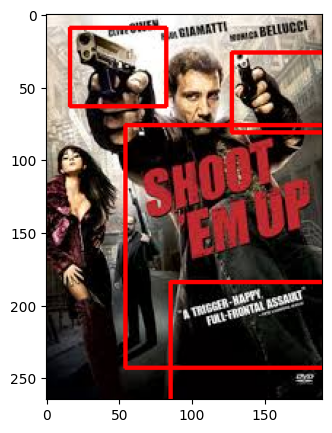

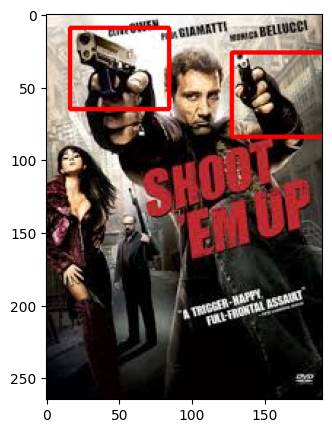

In [21]:
outputs, ground, img = test(dataset, number=10)

nms_prediction = apply_nms(outputs[0], iou_thresh=0.7)

plot_img_bbox(torch_to_pil(img), nms_prediction)
plot_img_bbox(torch_to_pil(img), ground)